In [1]:
import heeps
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.pupil.create_lyotstop import create_ls
from heeps.util.img_processing import resize_img, pad_img, crop_img, oversamp
from heeps.util.round2odd import round2odd
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper.prop_get_amplitude as get_amplitude
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import warnings
%matplotlib inline

### Inputs

In [2]:
pupil_img_size = 39.9988    # pupil image in m
nimg = 10526                # size of the high-res pupil image
print('pupil_img_size = %s m'%pupil_img_size)
print('nimg = %s'%nimg)
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# RA optimal diameter
diam_ravc_opt = 18.637 # (r_opt=0.505)
# spider width in m
spi_width = 0.54
# METIS "pupil image" size in mm
pupil_img_size_METIS = {'IMG': 45/diam_nominal_ext*pupil_img_size, 
                        'LMS': 28/diam_nominal_ext*pupil_img_size}
print('pupil_img_size_METIS = %s mm'%dict((x, round(y, 2)) 
    for x, y in pupil_img_size_METIS.items()))
# Huygens PSF data
dir_data = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/pupil_blurring/data'))
data_spacing = 0.014239     # in mm
npupil_conv = dict((x, int(np.ceil(y/data_spacing))) 
    for x, y in pupil_img_size_METIS.items())
print('npupil_conv = %s'%npupil_conv)
# 2D map
npup = 31
nspi = 31
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# parameters at each band
phot_spiders = {'L' :3.5,   # pixels on the spiders (for 1 inside the pupil)
                'N2':4.3}
phot_envirnt = {'L' :4.3,   # pixels outside the pupil (for 1 inside the pupil)
                'N2':5.1}
npupil_scaling = 4
npupil = {'L': update_config(**dict(read_config(), band='L'))['npupil'],
          'N2':update_config(**dict(read_config(), band='N2'))['npupil']}
print('npupil = %s'%npupil)

pupil_img_size = 39.9988 m
nimg = 10526
pupil_img_size_METIS = {'IMG': 46.7, 'LMS': 29.06} mm
npupil_conv = {'IMG': 3280, 'LMS': 2041}
npupil = {'L': 285, 'N2': 119}


### Create pupils

In [3]:
eso = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil/eso'))
maskM1 = fits.getdata(os.path.join(eso, 'mask_fullM1.fits'))
spiders = fits.getdata(os.path.join(eso, 'SpiderShadow.fits'))
pickle_eso = os.path.join(eso, 'pup_eso.pkl')
if os.path.isfile(pickle_eso):
    pup_eso = pickle.load(open(pickle_eso,'rb'))
else:
    pup_eso = dict((x, resize_img(maskM1*spiders, y))
                for x, y in npupil_conv.items())
    with open(pickle_eso, 'wb') as file:
        pickle.dump(pup_eso, file)
        file.close()
pickle_bkg = os.path.join(eso, 'pup_bkg.pkl')
if os.path.isfile(pickle_bkg):
    pup_bkg = pickle.load(open(pickle_bkg,'rb'))
else:
    pup_bkg = dict((x, dict((band, resize_img(maskM1*((1 - spiders)*phot_spi) 
                    + (1 - maskM1)*phot_env, y)) 
                    for (band, phot_spi), (band, phot_env) 
                    in zip(phot_spiders.items(), phot_envirnt.items())))
                for x, y in npupil_conv.items())
    with open(pickle_bkg, 'wb') as file:
        pickle.dump(pup_bkg, file)
        file.close()

### Define functions

In [4]:
def conv_pupil(conf, plane, data, i, npupil_scaling=npupil_scaling):
    # 1/ load kernel (Huygens PSF)
    filename = conf['dir_output'] + 'data_%s_kernel.fits'%i
    if os.path.isfile(filename):
        kernel = fits.getdata(filename)
    else:
        kernel = np.loadtxt(data%i, delimiter='\t', encoding='utf-16', skiprows=21)
        kernel = np.delete(kernel, 0, 0)
        kernel = np.delete(kernel, 0, 1)
        fits.writeto(filename, kernel, overwrite=True)
    nkernel = kernel.shape[-1]
    band = conf['band']
    print('background:')
    print('   nkernel = %s, kernel_size = %.2f mm'%(nkernel, nkernel*data_spacing))
    print('   npupil = %s'%npupil[band])
    # 2/ convolve background thermal emission with kernel
    filename = conf['dir_output'] + 'data_%s_blurred_bkg.fits'%i
    if os.path.isfile(filename):
        pup_bkg_conv = fits.getdata(filename)
    else:
        pup_bkg_conv = astroconv.convolve(pup_bkg[plane][band], kernel, boundary='extend')
        pup_bkg_conv = resize_img(pup_bkg_conv, npupil[band])
        fits.writeto(filename, pup_bkg_conv, overwrite=True)
    # 3/ convolve M1 pupil with kernel
    filename = conf['dir_output'] + 'data_%s_blurred_pupil.fits'%i
    if os.path.isfile(filename):
        pup_conv = fits.getdata(filename)
    else:
        pup_conv = astroconv.convolve(pup_eso[plane], kernel, boundary='extend')
        pup_conv = resize_img(pup_conv, npupil[band])
        fits.writeto(filename, pup_conv, overwrite=True)
    # 4/ resample kernel
    nkernel_resized = round2odd(nkernel*npupil_scaling*npupil[band]/npupil_conv[plane])
    kernel_hci = resize_img(kernel, nkernel_resized)
    npupil_resized = npupil_conv[plane]*nkernel_resized/nkernel
    to_pad, to_resize = oversamp(nimg, npupil_resized, precision=1e-2)
    pup_hci = resize_img(pad_img(maskM1*spiders, to_pad), to_resize)
    pupil_img_size_scaled = pupil_img_size*to_resize/(npupil_scaling*npupil[band])
    print('HCI:')
    print('   npupil_scaling = %s'%npupil_scaling)
    print('   nkernel_resized = %s, npupil_resized = %s'
        %(nkernel_resized, npupil_resized))
    print('   nimg = %s, to_pad = %s, to_resize = %s'%(nimg, to_pad, to_resize))
    print('   pupil_img_size_scaled = %s'%pupil_img_size_scaled)
    # 5/ figure
    c = pup_conv.shape[0]/2
    cext = c/pupil_img_size*diam_allglass_ext
    cint = c/pupil_img_size*diam_allglass_int
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.1, 1, 1])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.subplot(gs[0]); plt.title('kernel (log10)')
        plt.imshow(np.log10(kernel), origin='lower', cmap='inferno')
        plt.colorbar(cax=fig.add_axes([0.33, 0.17, 0.01, 0.65]))
        vmin, vmax = -1, 1 #log10
        plt.subplot(gs[2]); plt.title('blurred background (log10)')
        plt.imshow(np.log10(pup_bkg_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[2].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[2].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
        plt.subplot(gs[3]); plt.title('blurred pupil (log10)')
        plt.imshow(np.log10(pup_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[3].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[3].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
    plt.colorbar(cax=fig.add_axes([0.85, 0.17, 0.01, 0.65]))
    plt.subplots_adjust(right=0.84) # for colorbar
    plt.savefig(conf['dir_output'] + 'data_%s_blurring.png'%i, dpi=300, transparent=True)
    return pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled

def cold_stop(conf, r_pup, r_spi, circ_int=False):
    conf.update(ls_dRext=r_pup, ls_dRint=r_pup, ls_dRspi=r_spi)
    diam_int = diam_allglass_int if circ_int == False else diam_ravc_opt
    cs = create_ls(diam_allglass_ext, diam_int, circ_ext=False, circ_int=circ_int, **conf)
    return cs

def bkg_case(pup_bkg_conv, wf, conf, r_pup, r_spi):
    conf['ls_mask'] = cold_stop(conf, r_pup, r_spi)
    # thruput
    amp = get_amplitude(heeps.optics.lyot_stop(deepcopy(wf), **conf))
    bkg_thruput = np.sum(amp)
    # relative flux from blurred background
    bkg_blur = np.sum(conf['ls_mask']*pup_bkg_conv)/bkg_thruput
    return bkg_blur, bkg_thruput
    
def bkg_case_2d(pup_bkg_conv, conf, i):
    confi = deepcopy(conf)
    filename = confi['dir_output'] + 'data_%s_bkg_thruput.fits'%i
    if os.path.isfile(filename):
        bkg_blur = fits.getdata(confi['dir_output'] + 'data_%s_bkg_blur.fits'%i)
        bkg_thruput = fits.getdata(confi['dir_output'] + 'data_%s_bkg_thruput.fits'%i)
    else:
        wf = heeps.pupil.pupil(norm_I=False, verbose=True, **confi)
        out1, out2 = multiCPU(bkg_case, nout=2, verbose=True,
            posargs=[pup_bkg_conv, wf, confi],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)])
        bkg_blur = out1.reshape(npup, nspi)
        bkg_thruput = out2.reshape(npup, nspi)
        fits.writeto(confi['dir_output'] + 'data_%s_bkg_blur.fits'%i, bkg_blur)
        fits.writeto(confi['dir_output'] + 'data_%s_bkg_thruput.fits'%i, bkg_thruput)
    return bkg_blur, bkg_thruput

def hci_case(ls_leak, conf, wf, r_pup, r_spi):
    # update cold stop
    conf['ls_mask'] = cold_stop(conf, r_pup, r_spi, circ_int=('RAVC' in conf['mode']))
    # thruput
    amp = get_amplitude(heeps.optics.lyot_stop(deepcopy(wf), **conf))
    hci_thruput = np.sum(amp)
    if 'VC' in conf['mode']:
        # VPM leakage
        wf1 = heeps.optics.lyot_stop(deepcopy(wf), **conf)
        psf1 = heeps.optics.detector(wf1, **conf)
        # blur lyot stop pupil
        conf['ls_mask'] *= ls_leak
        wf2 = heeps.optics.lyot_stop(deepcopy(wf), **conf)
        psf2 = heeps.optics.detector(wf2, **conf)
        # relative leakage from blurred pupil
        hci_blur = np.sum(psf2)/np.sum(psf1) - 1
    elif 'APP' in conf['mode']:
        # p2v flux from blurred pupil
        hci_blur = 1 - np.min(amp)
    return hci_blur, hci_thruput

def hci_case_2d(conf, pup_M1, kernel_hci, i, pupil_img_size_scaled, 
        npupil_scaling=npupil_scaling):
    confi = deepcopy(conf)
    filename = confi['dir_output'] + 'data_%s_hci_thruput.fits'%i
    if os.path.isfile(filename):
        hci_blur = fits.getdata(confi['dir_output'] + 'data_%s_hci_blur.fits'%i)
        hci_thruput = fits.getdata(confi['dir_output'] + 'data_%s_hci_thruput.fits'%i)
    else:
        confi['npupil'] = pup_M1.shape[-1]
        if 'VC' in confi['mode']:
            confi['ngrid'] = 1024*npupil_scaling
            confi['pupil_img_size'] = pupil_img_size_scaled
            confi = heeps.config.update_config(**confi, verbose=True)
            wf = heeps.pupil.pupil(pup=pup_M1, **confi, verbose=True)
            wf = heeps.optics.apodizer(wf, **confi, verbose=True)
            wf = heeps.optics.fp_mask(wf, **confi, verbose=True)
            filename = confi['dir_output'] + 'data_%s_ls_leak.fits'%i
            if os.path.isfile(filename):
                ls_leak = fits.getdata(filename)
            else:
                amp1 = crop_img(get_amplitude(wf), confi['npupil'])
                amp2 = astroconv.convolve(amp1, kernel_hci, boundary='extend')
                ls_leak = amp2/amp1
                fits.writeto(confi['dir_output'] + 'data_%s_ls_leak.fits'%i, ls_leak)
        elif 'APP' in confi['mode']:
            wf = heeps.pupil.pupil(pup=pup_M1, **confi)
            ls_leak = 0
        out1, out2 = multiCPU(hci_case, nout=2, verbose=True,
            posargs=[ls_leak, confi, wf],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)])
        hci_blur = out1.reshape(npup, nspi)
        hci_thruput = out2.reshape(npup, nspi)
        fits.writeto(confi['dir_output'] + 'data_%s_hci_blur.fits'%i, hci_blur)
        fits.writeto(confi['dir_output'] + 'data_%s_hci_thruput.fits'%i, hci_thruput)
    return hci_blur, hci_thruput

def plot_2d_map(conf, blur, thruput, i, rs_opt, rp_opt, title):
    _, ax = plt.subplots(figsize = (8,6))
    plt.imshow(np.log10(blur), origin='lower', aspect='auto', cmap='viridis', 
        extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.colorbar()
    f_blur = interp2d(rs, rp, blur)
    f_thruput = interp2d(rs, rp, thruput)
    optim = f_blur(rs_opt, rp_opt)
    def fmt(x, optim=optim):
        return '%.2e'%10**(x) if np.isclose(10**x, optim) else '%.0e'%10**(x)
    print('red cross = %s (%.2f%%, %.2f%%)'
    %(fmt(np.log10(optim)), rs_opt*100, rp_opt*100))

    cs_min = int(np.ceil(np.log10(np.min(blur))))
    cs_max = int(np.floor(np.log10(np.max(blur))))
    cs_vals = np.append(np.log10(optim), np.arange(cs_min, cs_max + 1))
    cs_ls = np.append(':', ['-']*(len(cs_vals) - 1))
    cs_ls = cs_ls[np.argsort(cs_vals)]
    cs_vals = np.sort(cs_vals)
    CS = ax.contour(np.log10(blur), cs_vals, colors='magenta', linewidths=2, 
        linestyles=cs_ls, extent=(rs[0],rs[-1],rp[0],rp[-1]))
    lx = []
    ly = []
    for j,c in enumerate(CS.collections):
        v = c.get_paths()[0].vertices
        x = v[:,0]
        y = v[:,1]
        t = np.array([f_thruput(s,p) for s,p in zip(x,y)])
        k = np.argmax(t)
        plt.scatter(x[k], y[k], s=150, c='magenta', marker='+')
        print('optim %s = %s (%.2f%%, %.2f%%)'
            %(j, fmt(cs_vals[j]), x[k]*100, y[k]*100))
        lx.append(x[k]+5e-3)
        ly.append(y[k])#-5e-3)

    manual = np.array([lx,ly]).T
    ax.clabel(CS, CS.levels, fontsize=12, inline=True, manual=manual, fmt=fmt)

    plt.scatter(rs_opt, rp_opt, s=150, c='red', marker='+')
    plt.xlim(rs[0], rs[-1])
    plt.ylim(rp[0], rp[-1])
    plt.xlabel('ls_dRspi (%)')
    plt.ylabel('ls_dRext & ls_dRint (%)')
    plt.title(title)
    ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
    ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
    tag = 'bkg' if 'background' in title else 'hci'
    plt.savefig(conf['dir_output'] + 'data_%s_2d_map_%s.png'
        %(i, tag), dpi=300, transparent=True)

# IMG 6" circular (L-band VPM)

In [5]:
# optimal lyot stop params
rs_opt = 0.0333#0.0317
rp_opt = 0.0307#0.0291
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_6"',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'RAVC',
        ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_VPM_sweetspot1_pp1.txt

background:
   nkernel = 127, kernel_size = 1.81 mm
   npupil = 285
HCI:
   npupil_scaling = 4
   nkernel_resized = 45, npupil_resized = 1162.2047244094488
   nimg = 10526, to_pad = 10805, to_resize = 1193
   pupil_img_size_scaled = 41.85839333333334


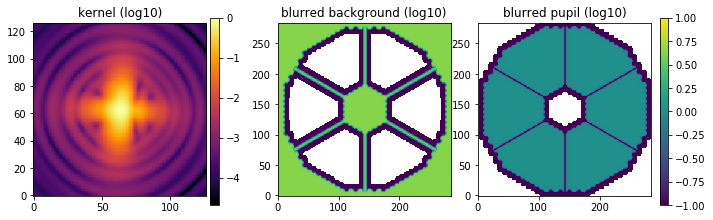

In [6]:
data = os.path.join(dir_data, 'IMG_VPM_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

red cross = 2.71e-04 (3.33%, 3.07%)
optim 0 = 1e-06 (5.25%, 6.00%)
optim 1 = 1e-05 (4.60%, 5.00%)
optim 2 = 1e-04 (3.69%, 3.80%)
optim 3 = 2.71e-04 (3.25%, 3.20%)
optim 4 = 1e-03 (2.40%, 2.37%)
optim 5 = 1e-02 (0.92%, 0.80%)


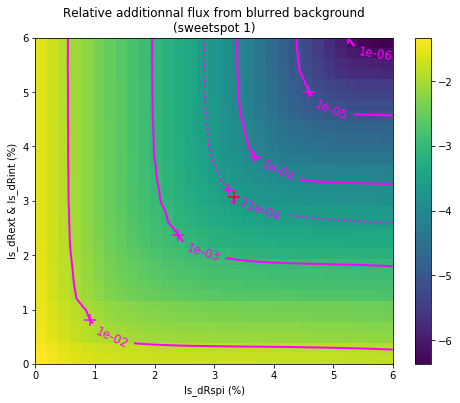

In [7]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

red cross = 7.17e-03 (3.33%, 3.07%)
optim 0 = 7.17e-03 (4.00%, 2.91%)
optim 1 = 1e-02 (3.60%, 2.11%)
optim 2 = 1e-01 (0.43%, 0.00%)


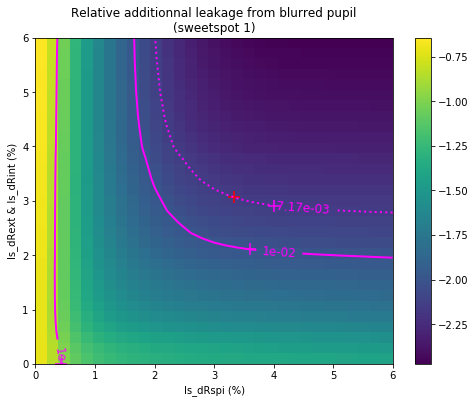

In [8]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_VPM_sweetspot2_pp1.txt

background:
   nkernel = 127, kernel_size = 1.81 mm
   npupil = 285
HCI:
   npupil_scaling = 4
   nkernel_resized = 45, npupil_resized = 1162.2047244094488
   nimg = 10526, to_pad = 10805, to_resize = 1193
   pupil_img_size_scaled = 41.85839333333334


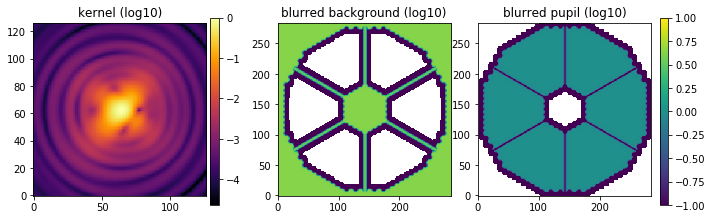

In [9]:
data_i = 2
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

red cross = 2.85e-04 (3.33%, 3.07%)
optim 0 = 1e-06 (5.34%, 6.00%)
optim 1 = 1e-05 (4.72%, 5.00%)
optim 2 = 1e-04 (3.77%, 3.80%)
optim 3 = 2.85e-04 (3.25%, 3.20%)
optim 4 = 1e-03 (2.40%, 2.33%)
optim 5 = 1e-02 (0.76%, 0.80%)


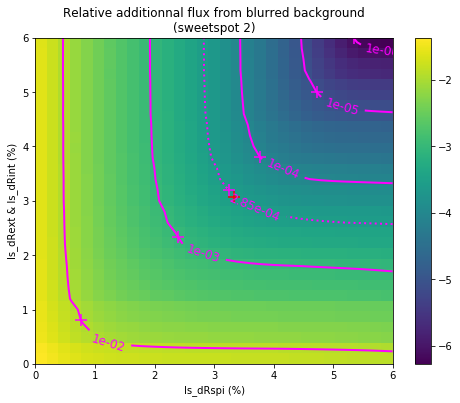

In [10]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

red cross = 7.17e-03 (3.33%, 3.07%)
optim 0 = 7.17e-03 (4.00%, 2.91%)
optim 1 = 1e-02 (3.60%, 2.11%)
optim 2 = 1e-01 (0.43%, 0.00%)


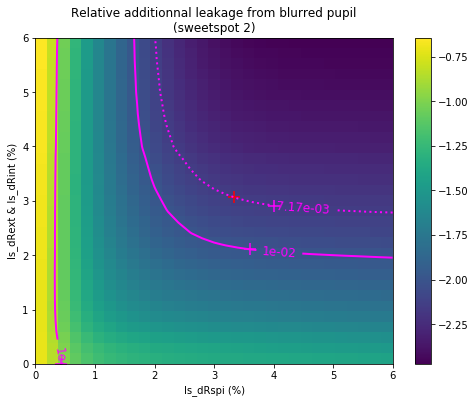

In [11]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_VPM_sweetspot3_pp1.txt

In [ ]:
data_i = 3
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

background:
   nkernel = 127, kernel_size = 1.81 mm
   npupil = 285


In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

# IMG 10.85" (L-band img classical + APP)

In [ ]:
# optimal lyot stop params
rs_opt = 0.0517
rp_opt = 0.0491
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_10.85"',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'APP',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_10.85_sweetspot1_pp1.txt

In [ ]:
data = os.path.join(dir_data, 'IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_conv, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_10.85_sweetspot2_pp1.txt

In [ ]:
data_i = 2
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_conv, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_10.85_sweetspot3_pp1.txt

In [ ]:
data_i = 3
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_conv, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

# IMG 14" (N-band img classical + VPM)

In [ ]:
# optimal lyot stop params
rs_opt = 0.0645
rp_opt = 0.0619
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_N_field_14"',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'N2',
        mode = 'CVC',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_14_sweetspot1_pp1.txt

In [ ]:
data = os.path.join(dir_data, 'IMG_14_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_14_sweetspot2_pp1.txt

In [ ]:
data_i = 2
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)

### IMG_14_sweetspot3_pp1.txt

In [ ]:
data_i = 3
pup_bkg_conv, pup_conv, pup_hci, kernel_hci, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)

In [ ]:
bkg_blur, bkg_thruput = bkg_case_2d(pup_bkg_conv, conf, data_i)
plot_2d_map(conf, bkg_blur, bkg_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal flux from blurred background\n(sweetspot %s)'%data_i)

In [ ]:
hci_blur, hci_thruput = hci_case_2d(conf, pup_hci, kernel_hci, data_i, pupil_img_size_scaled)
plot_2d_map(conf, hci_blur, hci_thruput, data_i, rs_opt=rs_opt, rp_opt=rp_opt, 
    title='Relative additionnal leakage from blurred pupil\n(sweetspot %s)'%data_i)